# Prediction of Atmospheric Carbon Dioxide (C02)

We will use data from:

https://gml.noaa.gov/ccgg/trends/data.html

Data are measured at Mauna Loa, Hawai, USA

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Let's load some data (don't read!)

In [3]:
data_full = pd.read_csv("data/co2_mm_mlo.txt", 
                        comment="#", delim_whitespace=True, index_col=False,
                        usecols=[0, 1, 3],
                        names=["year", "month", "co2"])
month_to_int = dict(january=1, february=2, march=3, april=4, may=5, june=6, july=7, august=8,
                    september=9, october=10, november=11, december=12)
int_to_month = {v:k for k, v in month_to_int.items()}
data_full["month"] = data_full["month"].apply(lambda m: int_to_month[m])
data = data_full[data_full["year"] > 2008].copy()
data = data.reset_index().drop("index", axis=1)
data.head()

,year,month,co2
0,2009,january,387.17
1,2009,february,387.70
2,2009,march,389.04
3,2009,april,389.76
4,2009,may,390.36


In [4]:
data.month

0       january
1      february
2         march
3         april
4           may
         ...   
146       march
147       april
148         may
149        june
150        july
Name: month, Length: 151, dtype: object

<div class="alert alert-success">
    <b>Questions:</b>
     <ul>
      <li>what is X? what is y?</li>
      <li>how would you evaluate your forecasting model?</li>
    </ul>
</div>

<AxesSubplot:>

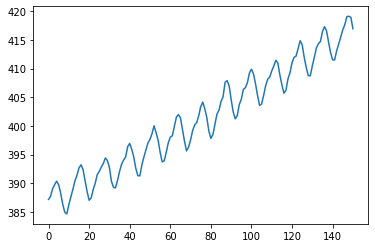

In [5]:
data.co2.plot()

## Convert all variables to numeric

In [6]:
data["month"] = data["month"].apply(lambda m: month_to_int[m] - 1).astype(int)
data.head()

,year,month,co2
0,2009,0,387.17
1,2009,1,387.70
2,2009,2,389.04
3,2009,3,389.76
4,2009,4,390.36


In [7]:
data.dtypes

year       int64
month      int64
co2      float64
dtype: object

In [8]:
data['time'] = data['year'] + data['month'] / 12.

In [9]:
data.time

0      2009.000000
1      2009.083333
2      2009.166667
3      2009.250000
4      2009.333333
          ...     
146    2021.166667
147    2021.250000
148    2021.333333
149    2021.416667
150    2021.500000
Name: time, Length: 151, dtype: float64

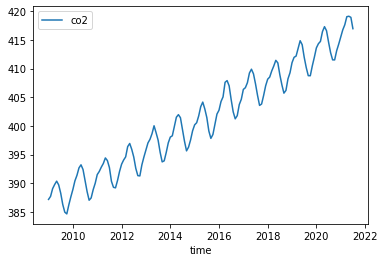

In [10]:
data.plot(x='time', y='co2');  # visualize the data

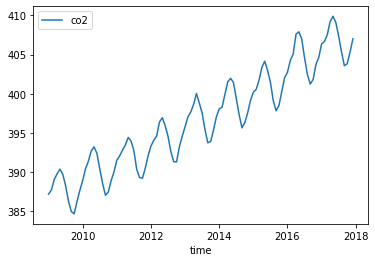

In [11]:
data_train = data[data["year"] < 2018]  # take history as training data
data_test = data[data["year"] >= 2018]  # rest will be testing data
data_train.plot(x='time', y='co2');

Let's now define an X and y

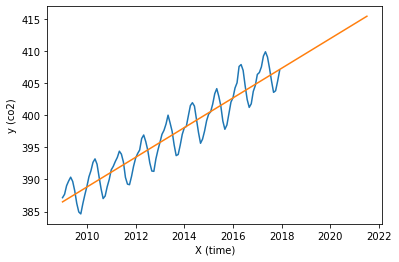

In [12]:
X = data["time"].values[:, np.newaxis]
X_train = data_train["time"].values[:, np.newaxis]
y_train = data_train["co2"]

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

plt.plot(data_train["time"], data_train["co2"]);
plt.plot(X, model.predict(X))
plt.xlabel('X (time)')
plt.ylabel('y (co2)');

Fit does not capture seasonality.

Let's add non-linear feature, namely the cosine and sine of the period of a year.


$CO2 = \theta_1 * \textrm{ year } + \theta_2 * \cos(2 \pi \textrm{ month } / 12) + \theta_3 * \sin(2 \pi \textrm{ month } / 12) + \theta_0$

In [13]:
X = np.stack(
    [
        data["year"],
        np.cos(data["month"] / 12. * 2 * np.pi),
        np.sin(data["month"] / 12. * 2 * np.pi),
        np.cos(data["month"] / 24. * 2 * np.pi),
        np.sin(data["month"] / 24. * 2 * np.pi),
    ], axis=1)
X.shape

(151, 5)

In [14]:
y = data['co2']
y

0      387.17
1      387.70
2      389.04
3      389.76
4      390.36
        ...  
146    417.64
147    419.05
148    419.13
149    418.94
150    416.96
Name: co2, Length: 151, dtype: float64

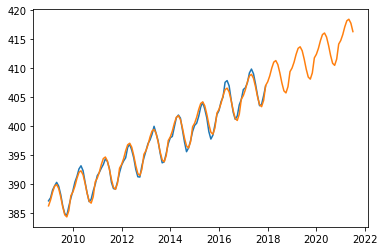

In [15]:
X_train = X[:len(data_train)]
X_train.shape

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

plt.plot(data_train["time"], data_train["co2"]);
plt.plot(data["time"], model.predict(X))

## Decomposition: `data = trend + seasonality + noise`

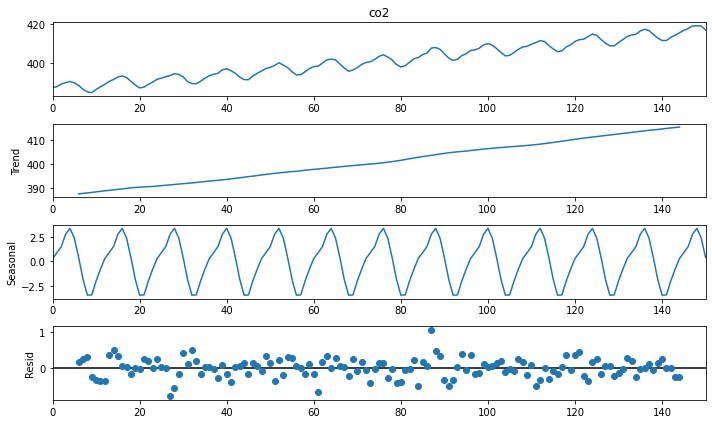

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_results = seasonal_decompose(data["co2"], period=12, model='add')

with plt.rc_context({'figure.figsize': (10, 6)}):
    seasonal_results.plot()

## Doing the model evaluation with cross-validation using scikit-learn

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
TimeSeriesSplit?

Init signature: TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)
Docstring:     
Time Series cross-validator

Provides train/test indices to split time series data samples
that are observed at fixed time intervals, in train/test sets.
In each split, test indices must be higher than before, and thus shuffling
in cross validator is inappropriate.

This cross-validation object is a variation of :class:`KFold`.
In the kth split, it returns first k folds as train set and the
(k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive
training sets are supersets of those that come before them.

Read more in the :ref:`User Guide <time_series_split>`.

.. versionadded:: 0.18

Parameters
----------
n_splits : int, default=5
    Number of splits. Must be at least 2.

    .. versionchanged:: 0.22
        ``n_splits`` default value changed from 3 to 5.

max_train_size : int, default=None
    Maximum size for a single training set.

test_size 

In [19]:
from sklearn.model_selection import cross_val_score

cv = TimeSeriesSplit()
scores = cross_val_score(model, X, y, cv=cv)
scores

array([0.89159222, 0.93723784, 0.85381023, 0.94993223, 0.95033947])

In [20]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

model = linear_model.LinearRegression()
cv = TimeSeriesSplit(n_splits=5, max_train_size=36, test_size=12)
scores = cross_val_score(model, X, y, cv=cv)
print(f"Mean: {scores.mean(): .4f}  -- STD: {scores.std(): .4f}")

Mean:  0.9250  -- STD:  0.0684


<div class="alert alert-success">
    <b>EXERCISE:</b>
     <ul>
      <li>Evaluate the impact of the max_train_size parameter.
          How many months are enough to predict reasonably well?</li>
    </ul>
</div>

Solution: `solutions/02a-model_selection_time_series_split.py`

max_train_size: 6 -- Mean: -33.1145  -- STD:  24.1749
max_train_size: 12 -- Mean:  0.6448  -- STD:  0.2739
max_train_size: 18 -- Mean:  0.8967  -- STD:  0.0665
max_train_size: 24 -- Mean:  0.9153  -- STD:  0.0673
max_train_size: 30 -- Mean:  0.8979  -- STD:  0.0940
max_train_size: 36 -- Mean:  0.9250  -- STD:  0.0684
max_train_size: 42 -- Mean:  0.9342  -- STD:  0.0444


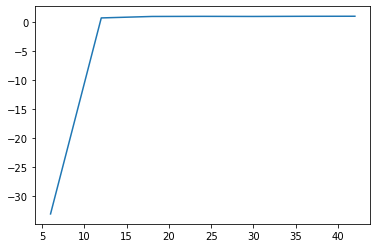

In [21]:
# %load solutions/02a-model_selection_time_series_split.py

max_train_sizes = range(6, 12*4, 6)
all_scores = []
for max_train_size in max_train_sizes:
    model = linear_model.LinearRegression()
    cv = TimeSeriesSplit(n_splits=5, max_train_size=max_train_size, test_size=12)
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"max_train_size: {max_train_size} -- Mean: {scores.mean(): .4f}  -- STD: {scores.std(): .4f}")
    all_scores.append(scores.mean())

plt.plot(max_train_sizes, all_scores)


<div class="alert alert-success">
    <b>EXERCISE:</b>
     <ul>
      <li>Use statsmodels to do the forecasting using an AR model.</li>
    </ul>
</div>

Solution: `solutions/02b-forecasting_AR_statsmodels.py`

Text(0.5, 1.0, 'forecast (statsmodels)')

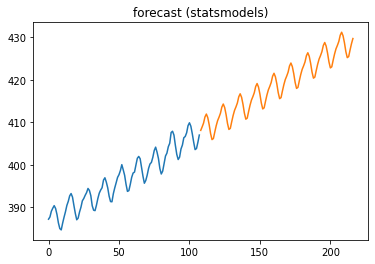

In [22]:
# %load solutions/02b-forecasting_AR_statsmodels.py

from statsmodels.tsa.ar_model import AutoReg

x = data_train["co2"].values
p = 3

ar_model = AutoReg(x, seasonal=True, lags=np.arange(1, p+1), trend='t', period=12).fit()
x_forecast = ar_model.predict(start=len(x), end=2*len(x))

t = np.arange(len(x))
t_forecast = len(x) + np.arange(len(x_forecast))
plt.plot(t, x)
plt.plot(t_forecast, x_forecast)
plt.title("forecast (statsmodels)")


# Automatic model selection with SARIMAX model

We will use the `pmdarima` package. To install it do:

`pip install pmdarima`

In [23]:
from pmdarima import auto_arima

# Automatic determination of sarima parameters
sarima_params_res = auto_arima(
    data_train['co2'],
    seasonal=True,  # Take into account for the seasonality
    m=12  # the length of our cycle (previously define = 12 month)
)

# sarima_params_res.summary()

# Get the paramaters:
arima_params = sarima_params_res.order
seasonal_params = sarima_params_res.seasonal_order

print(f'ARIMA parameters (p,d,q) = {arima_params}')
print(f'seasonal parameters (P,D,Q,m) =  {seasonal_params}')

/Users/camposgabriel/opt/miniconda3/envs/generic-ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/camposgabriel/opt/miniconda3/envs/generic-ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/camposgabriel/opt/miniconda3/envs/generic-ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/camposgabriel/opt/miniconda3/envs/generic-ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/camposgabriel/opt/miniconda3/envs/generic-ds/lib/python3.9/site-packages/

ARIMA parameters (p,d,q) = (2, 0, 0)
seasonal parameters (P,D,Q,m) =  (0, 1, 1, 12)


In [24]:
# model fitting using parameters fitted on the train data
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(data_train['co2'],
                       order=arima_params,
                       seasonal_order=seasonal_params)
results = sarima_model.fit()
# results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89561D-01    |proj g|=  8.21691D-01

At iterate    5    f=  4.61363D-01    |proj g|=  2.02875D-01

At iterate   10    f=  4.57723D-01    |proj g|=  6.31963D-02

At iterate   15    f=  4.29894D-01    |proj g|=  2.40467D-02

At iterate   20    f=  4.21796D-01    |proj g|=  2.46786D-02

At iterate   25    f=  4.21489D-01    |proj g|=  2.17255D-04


 This problem is unconstrained.



At iterate   30    f=  4.21488D-01    |proj g|=  3.06506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     55      1     0     0   3.065D-04   4.215D-01
  F =  0.42148842166800077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


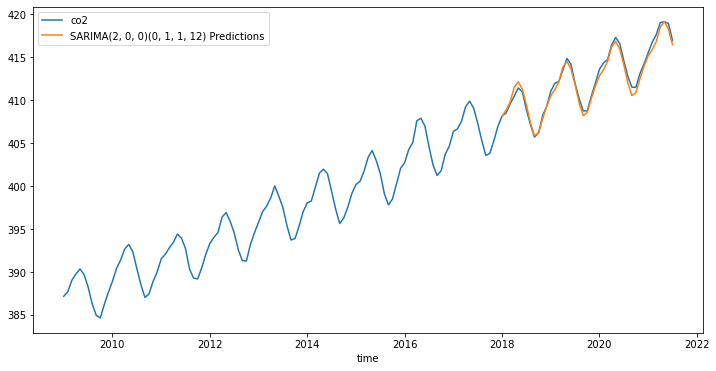

In [25]:
# Obtain predicted values and plot the predictions
start = len(data_train)
end = len(data)

predictions = results.predict(
    start=start,                     # time to start
    end=end,                         # time to end 
    dynamic=False,                   # use the full history to forecast
    typ='levels'                     # predict at the level of the original data (and not at the level of the differentiated one)
    ).rename(f'SARIMA{str(arima_params)}{str(seasonal_params)} Predictions')

pd.concat([data[["time", "co2"]], predictions], axis=1).plot(x="time", figsize=(12, 6));

<div class="alert alert-success">
    <b>EXERCISE:</b>
     <ul>
      <li>Use Prophet to do the forecasting.</li>
    </ul>
</div>

Prophet is a model that supports non-stationarities. It basically fits trends and seasonalities but over segments of data. It uses some rupture detection to know when to split in segments.

Solution: `solutions/02c-forecasting_prophet.py`

12:26:02 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/5 [00:00<?, ?it/s]

12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing
12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:29 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:31 - cmdstanpy - INFO - Chain [1] start processing
12:26:32 - cmdstanpy - INFO - Chain [1] done processing
12:26:33 - cmdstanpy - INFO - Chain [1] start processing
12:26:33 - cmdstanpy - INFO - Chain [1] done processing


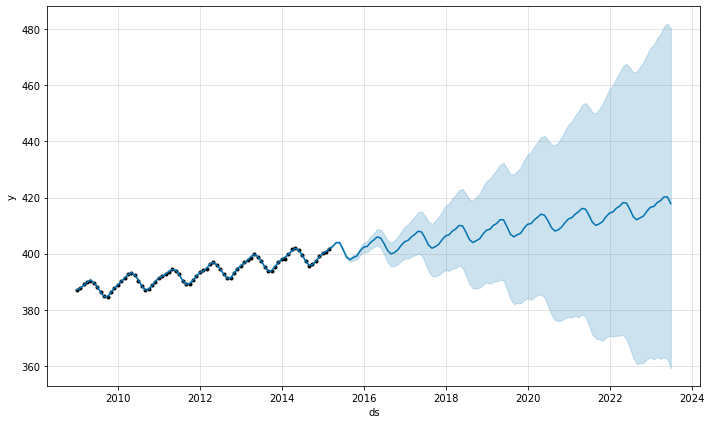

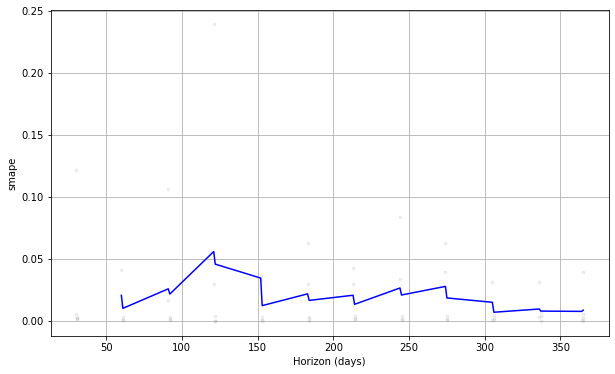

In [35]:
# %load solutions/02c-forecasting_prophet.py

# %% Setup dataset for Prophet (requires 2 columns "ds" and "y")
df = data.copy()
time_index = pd.to_datetime(
    {
        "year": df.year.values,
        "month": df.month.values + 1,
        "day": np.ones(len(data)),
    }
)
df.set_index(pd.Index(time_index), inplace=True)
df.reset_index(inplace=True)
df = df.rename({"co2": "y", "index": "ds"}, axis="columns")
df = df[["ds", "y"]]
df

# %% Do fitting with Prophet
from prophet import Prophet

df_train = df[:len(df) // 2]
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=100, freq="M")
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

# %% Do diagnostic plots
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

m = Prophet()
m.fit(df_train)
df_cv = cross_validation(
    m, initial='365 days', period='365 days', horizon='365 days'
)

fig2 = plot_cross_validation_metric(df_cv, metric='smape')


In [26]:
from prophet import Prophet

In [28]:
m = Prophet()
m.fit(data_train[['time', 'co2']].rename({'time': 'ds', 'co2': 'y'}))

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [33]:
data_train['ds'] = pd.Timestamp(year=data_train['year'], month=data_train['month'] + 1)

TypeError: cannot convert the series to <class 'int'>

To go beyond:

https://www.statsmodels.org/dev/tsa.html